Component 1: Nodes: 3 Edges: 2
Component 2: Nodes: 343 Edges: 417
Component 3: Nodes: 2 Edges: 1
Component 4: Nodes: 10 Edges: 9
Component 5: Nodes: 4 Edges: 3
Component 6: Nodes: 7 Edges: 6


  0%|          | 0/417 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 417/417 [11:42<00:00,  1.68s/it]


(16, 415, 4)
Cosine Similarity Threshold =  0.6
[0.02891206 0.5        0.05505669 0.02891206]
Cosine Similarity Threshold =  0.625
[0.02891206 0.5        0.05505669 0.02891206]
Cosine Similarity Threshold =  0.65
[0.02891206 0.5        0.05505669 0.02891206]
Cosine Similarity Threshold =  0.6749999999999999
[0.02891206 0.5        0.05505669 0.02891206]
Cosine Similarity Threshold =  0.7
[0.03354133 0.50005315 0.0548023  0.02901457]
Cosine Similarity Threshold =  0.725
[0.10068861 0.50068287 0.05095847 0.0302225 ]
Cosine Similarity Threshold =  0.75
[0.19628027 0.50210237 0.0476608  0.03297664]
Cosine Similarity Threshold =  0.7749999999999999
[0.32577937 0.51076518 0.05811898 0.04976981]
Cosine Similarity Threshold =  0.8
[0.49440231 0.5415238  0.10401739 0.11022623]
Cosine Similarity Threshold =  0.825
[0.51766825 0.60458899 0.20206343 0.23819414]
Cosine Similarity Threshold =  0.85
[0.52129826 0.67976983 0.32837113 0.42292477]
Cosine Similarity Threshold =  0.875
[0.52845577 0.735595

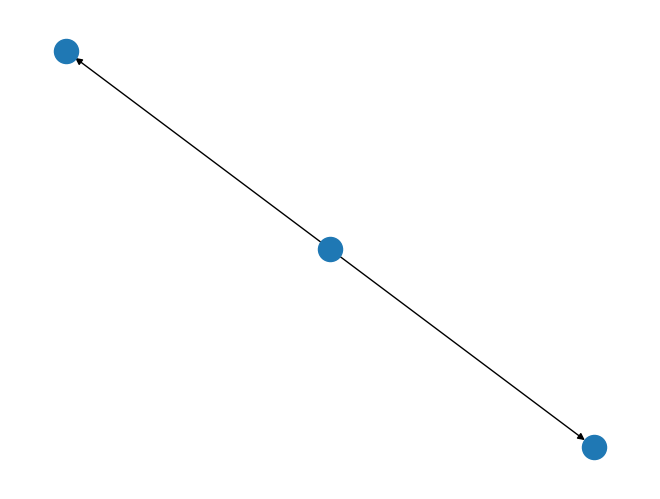

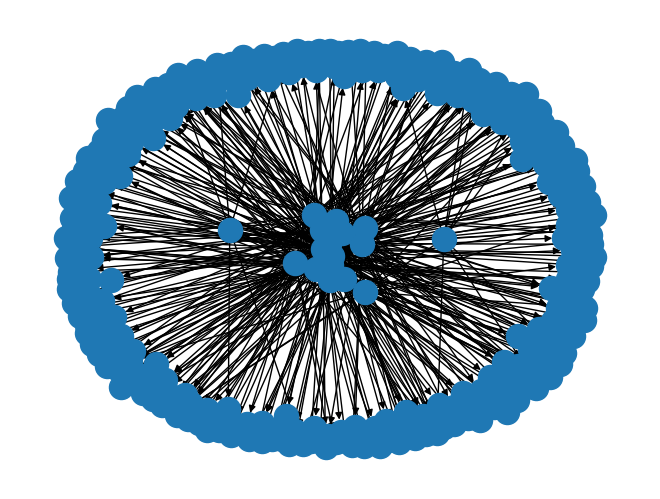

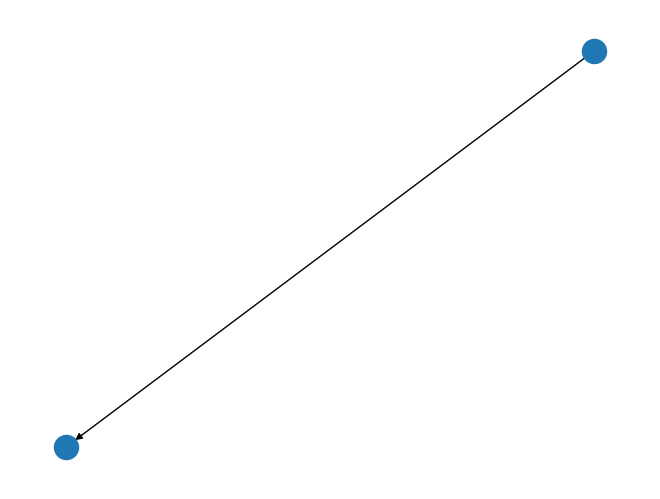

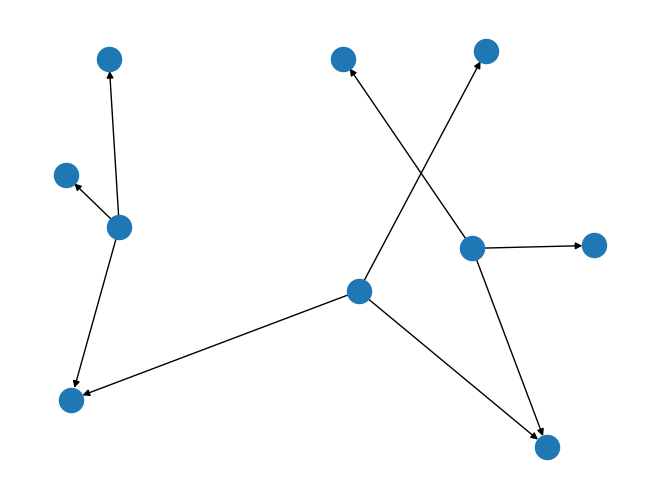

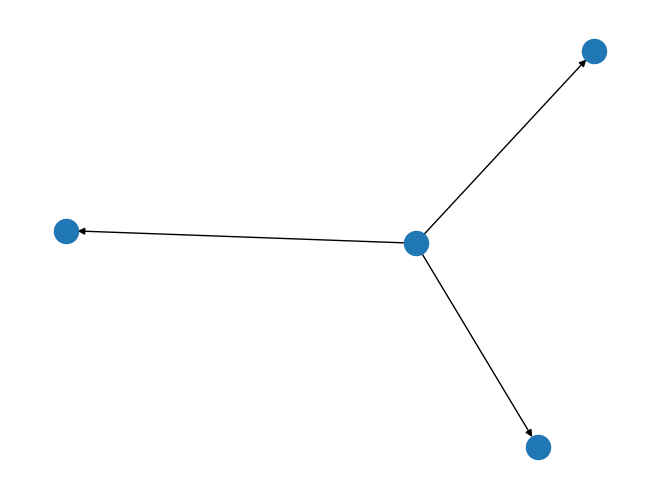

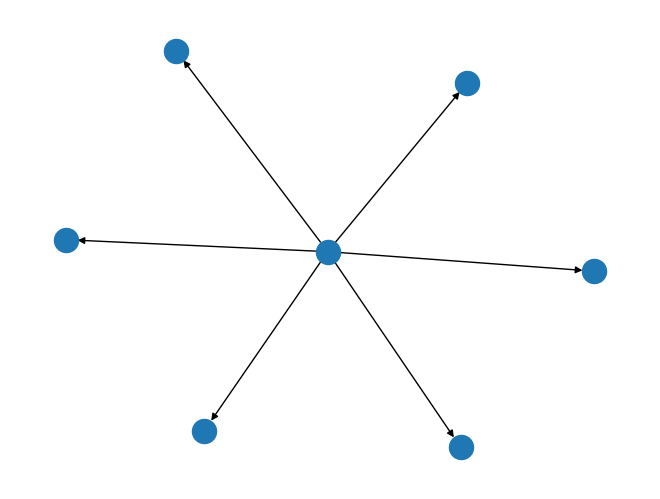

In [1]:
# %%
import pandas as pd
data = pd.read_csv("citation_data.csv")

# %%
data

# %%
grouped_data = data.groupby(["origin_dir", "reference_dir"]).agg({"block": list}).reset_index()

# %%
grouped_data

# %%
import networkx as nx
import matplotlib.pyplot as plt
G = nx.from_pandas_edgelist(grouped_data, source='origin_dir', target='reference_dir', edge_attr='block', create_using=nx.DiGraph())

# %%
components = [G.subgraph(c).copy() for c in nx.weakly_connected_components(G)]
for idx,g in enumerate(components,start=1): 
    print(f"Component {idx}: Nodes: {len(g.nodes())} Edges: {len(g.edges())}")
    plt.figure(idx)
    nx.draw(g)

# %%
import os
def find_cermxml(node):
    for root, dirs, files in os.walk(node):
        for file in files:
            if 'cermxml' in file:
                return os.path.join(root, file)
    return None

# %%
from jats_utils import JatsParser
from collections import OrderedDict
from tqdm import tqdm
component = components[1]
parser = JatsParser("arxiv_data")
embed_dict = OrderedDict()

from langchain.embeddings import HuggingFaceBgeEmbeddings, CacheBackedEmbeddings
from langchain.storage import LocalFileStore

base_path = "arxiv_mine/"

def embed_text(text, cache_name="cache"):
    model_name = "BAAI/bge-small-en"
    model_kwargs = {"device": "cuda"}
    encode_kwargs = {"normalize_embeddings": True}
    hf = HuggingFaceBgeEmbeddings(
        model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs)

    fs = LocalFileStore("./cache/" + cache_name)

    cached_embedder = CacheBackedEmbeddings.from_bytes_store(
        hf, fs, namespace=model_name
    )
    return cached_embedder.embed_documents(text)

import re

def get_node(node):

    paper = parser.get_blocks(node)
    paper = [re.sub(r"(ref[0-9]+)", " ", block) for block in paper]
    prompt = "Represent this sentence for searching relevant passages:"

    return np.array(embed_text([prompt + block for block in paper]))

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score


def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='macro', zero_division=np.nan)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=np.nan)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=np.nan)
    accuracy = (y_true == y_pred).mean()
    return precision, recall, f1, accuracy

# %%


metrics = [[] for _ in range(16)]

parser = JatsParser("arxiv_data")
for node1, node2 in tqdm(component.edges()):
    labels = component.get_edge_data(node1, node2)["block"]

    if "cermxml" not in node1:
        node1 = find_cermxml("arxiv_data_test/"+ node1.split("/")[-1])
    if "cermxml" not in node2:
        node2 = find_cermxml("arxiv_data_test/"+ node2.split("/")[-1])
    
    if not node1 or not node2:
        continue
    
    labels = [label in labels for label in parser.get_blocks(node1)]
    embed1 = get_node(node1)
    embed2 = get_node(node2)
    
    res = np.max(embed1 @ embed2.T, axis=1)
    
    for i in range(16):
        metrics[i].append(calculate_metrics(labels, res > 0.6 + (i)/40))
# %%
metrics

print(np.array(metrics).shape)

# %%
for i in range(16):
    print("Cosine Similarity Threshold = ", 0.6 + (i)/40)
    print(np.array(metrics[i]).mean(axis=0))

# %%

In [ ]:

for i in range(16):
    print("Cosine Similarity Threshold = ", 0.6 + (i)/40)
    print(np.array(metrics[i]).mean(axis=0))

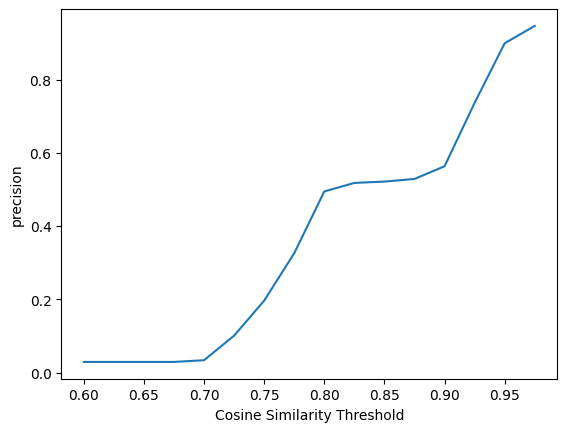

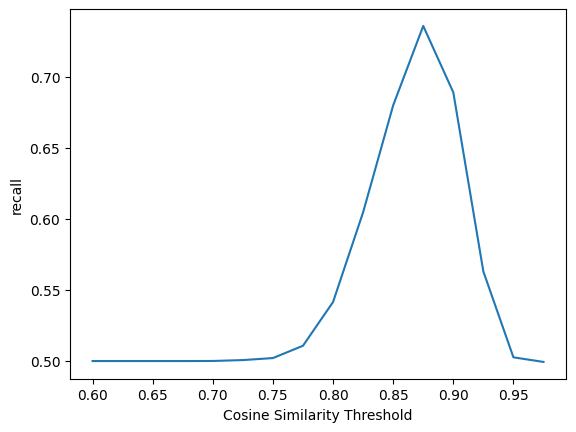

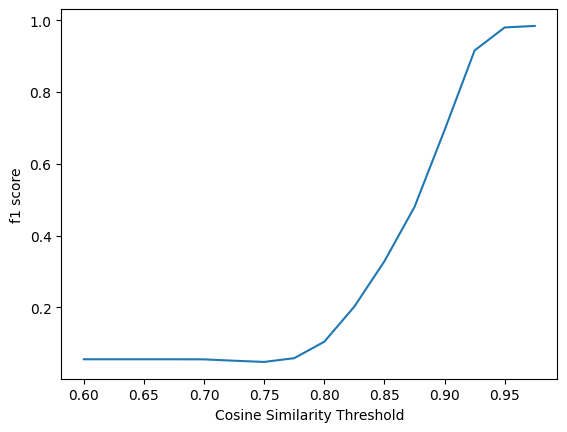

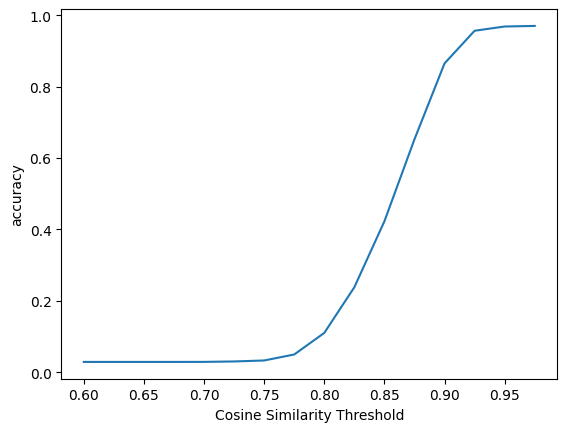

In [16]:
for i, x in enumerate(["precision", "recall", "f1 score", "accuracy"]):
    plt.figure()
    plt.plot(np.arange(0.6, 1, 0.025), np.mean(np.array(metrics), axis=1)[:, i], label=x)
    plt.xlabel("Cosine Similarity Threshold")
    plt.ylabel(x)
    plt.savefig(f"plots_{x}.pdf")

In [11]:
np.arange(0.6, 0.95, 0.025)

array([0.6  , 0.625, 0.65 , 0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  ,
       0.825, 0.85 , 0.875, 0.9  , 0.925])